In [2]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from random import randint

In [3]:
image_path = "../data/colmap-lego/images/r"
image_paths = []
for i in range (100):
    image_paths.append(image_path +"_"+ str(i) + ".png")

In [4]:
class K_means :
    def __init__(self, k, max_iters=400):
        self.k = k
        self.max_iters = max_iters
        self.cluster = []
        self.i = 0
        self.resample = 32
        self.data = []
        self.data_paths = []
        
        
    def euclidean_distance(self, a, b):
        distance = 0
        for i in range(len(a)):
            distance += (a[i]-b[i])**2
        return distance**0.5
    
    def chi2_distance(self,a, b):
        eps = 1e-10
        sum = 0
        for i in range(len(a)):
            sum += ((a[i]-b[i])**2)/(a[i]+b[i]+eps)
        return 0.5 * sum
                
    def read_image(self, im):
        try:
            img = Image.open(im)

            # Resize to consistent size
            img = img.resize((self.resample, self.resample))

            # Convert to grayscale and flatten
            arr = np.asarray(img.convert("L")).flatten().astype(np.float32)

            # Normalize to [0,1]
            arr /= 255.0

            return arr.tolist()

        except Exception as e:
            print(f"Error reading {im}: {e}")
            return None

    def generate_k_means(self):
        final_means = []
        for c in range(self.k):
            partial_mean = []
            for i in range(len(self.data[0])):
                s = 0
                t = 0
                for j in range(len(self.data)):
                    if self.cluster[j] == c:
                        s += self.data[j][i]
                        t += 1
                if t > 0:
                    partial_mean.append(s/t)
                else:
                    # avoid empty means → re-seed with random point
                    idx = np.random.randint(0, len(self.data))
                    partial_mean.append(self.data[idx][i])
            final_means.append(partial_mean)
        return final_means
    
    def assign_clusters(self, means):
        # update cluster assignment for every data point
        for i in range(len(self.data)):
            d_min = float('inf')
            idx = 0
            for c in range(self.k):
                d = self.chi2_distance(self.data[i], means[c])
                if d < d_min:
                    d_min = d
                    idx = c
            self.cluster[i] = idx

    def generate_clusters(self, means):
        clusters = [[] for _ in range(self.k)]
        for i in range(len(self.data)):
            clusters[self.cluster[i]].append(self.data_paths[i])
        return clusters
    
    def open_data_paths(self, paths):
        self.data_paths = []
        self.data = []
        for p in paths:
            im = self.read_image(p)
            if im is not None:
                self.data.append(im)
                self.data_paths.append(p)
        
        # initialize cluster assignments randomly
        self.cluster = np.random.randint(0, self.k, len(self.data)).tolist()

    def fit(self):
        for _ in range(self.max_iters):
            means = self.generate_k_means()
            self.assign_clusters(means)

        return self.generate_k_means(), self.generate_clusters(means)


In [5]:
kmean_images = K_means(k=6)
kmean_images.open_data_paths(image_paths)

_,clusters = kmean_images.fit()   # <-- THIS runs K-means properly



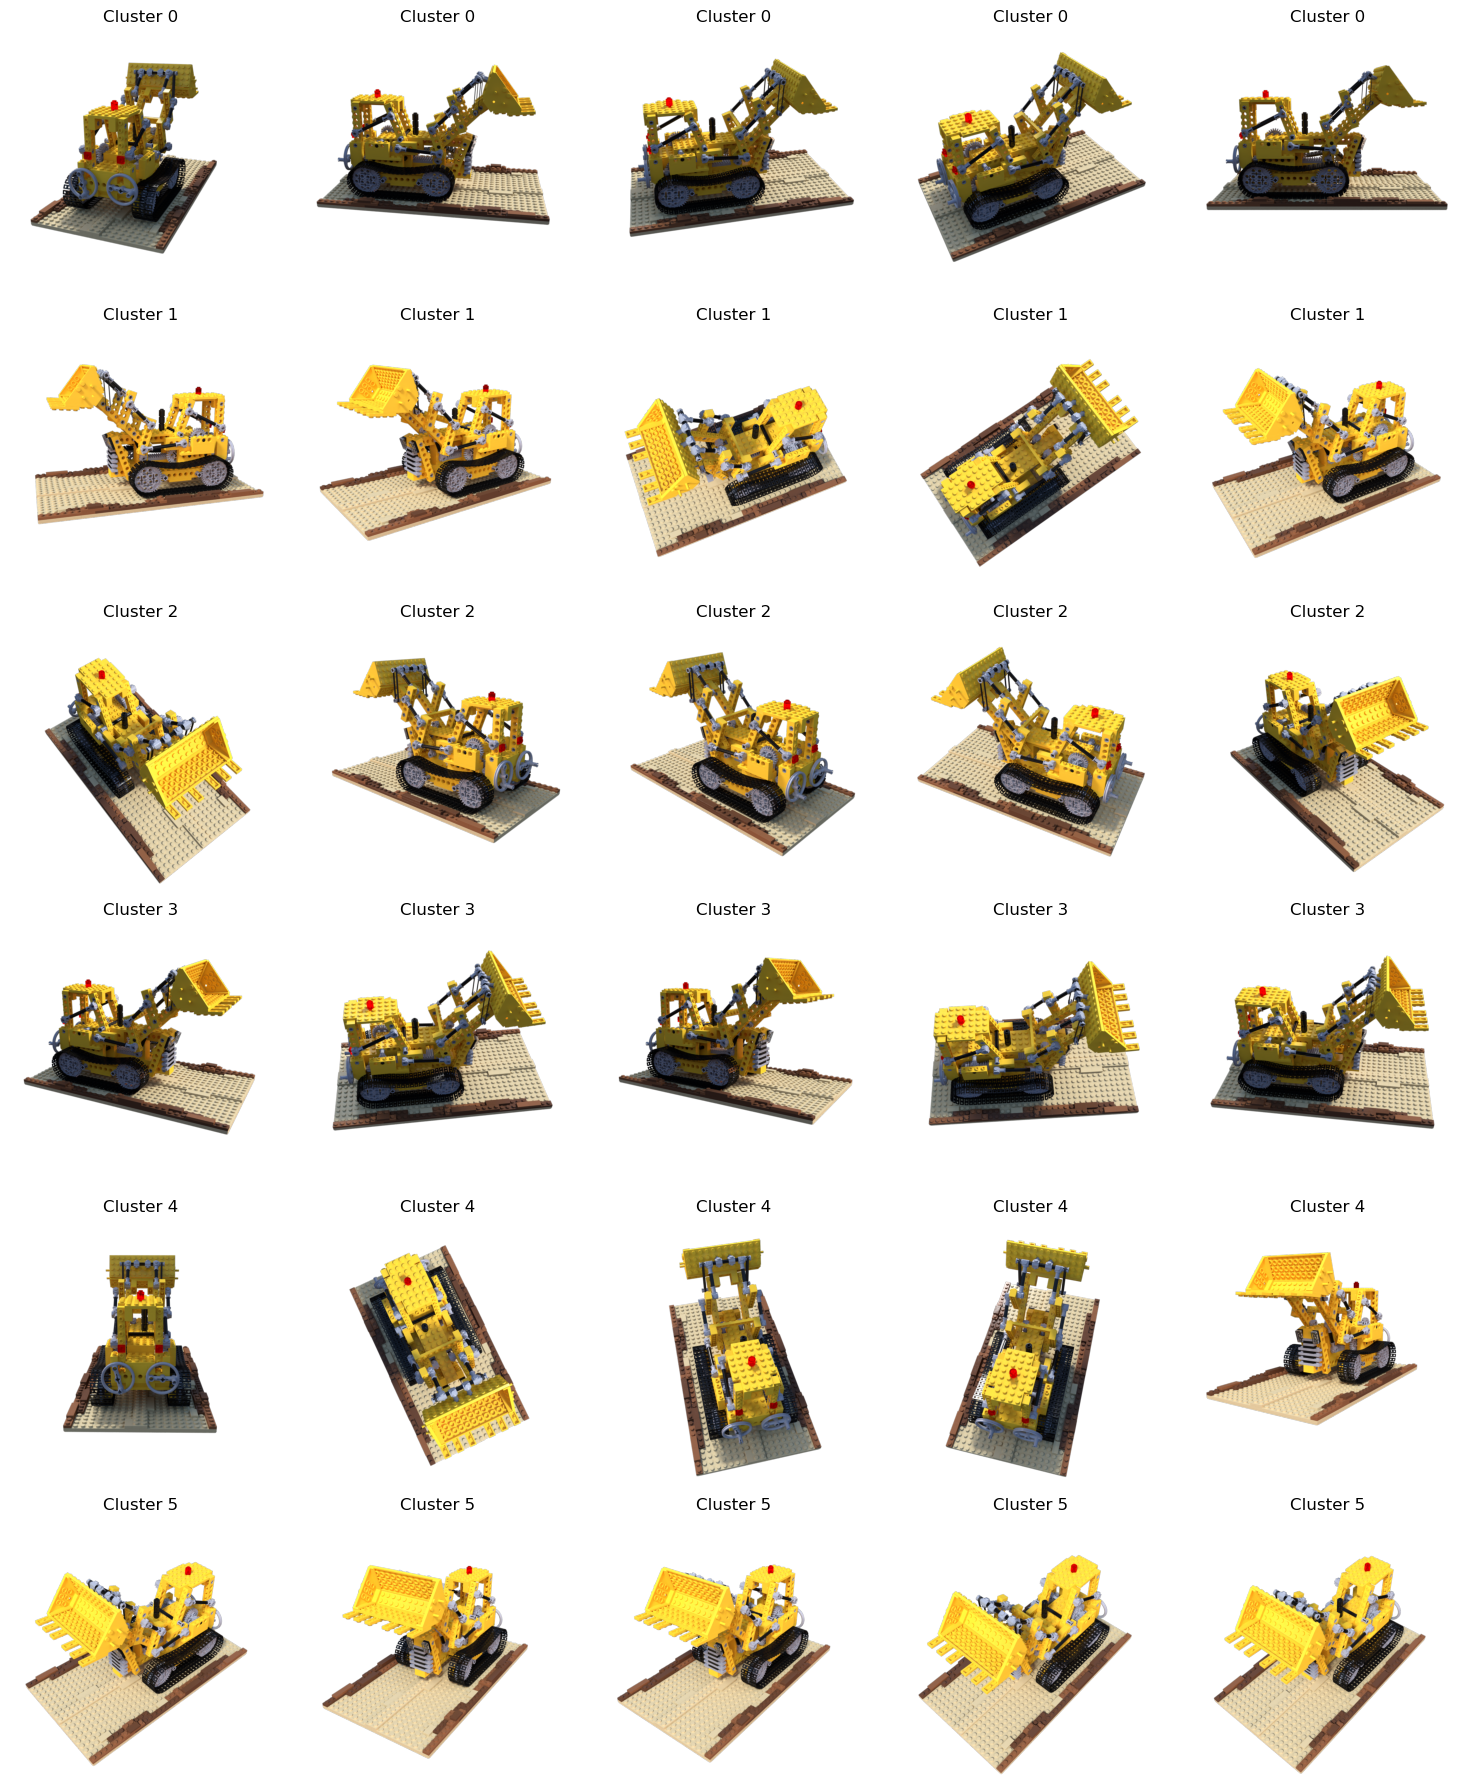

In [6]:
#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(kmean_images.k, 5, figsize=(15, 3*kmean_images.k))
for i in range(kmean_images.k):
    for j in range(5):
        if j < len(clusters[i]):
            img = Image.open(clusters[i][j])
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Cluster {i}")
        else:
            axs[i, j].axis('off')
plt.tight_layout()
plt.show()

Representative image for cluster 0: ../data/colmap-lego/images/r_40.png
Representative image for cluster 1: ../data/colmap-lego/images/r_80.png
Representative image for cluster 2: ../data/colmap-lego/images/r_22.png
Representative image for cluster 3: ../data/colmap-lego/images/r_16.png
Representative image for cluster 4: ../data/colmap-lego/images/r_39.png
Representative image for cluster 5: ../data/colmap-lego/images/r_6.png


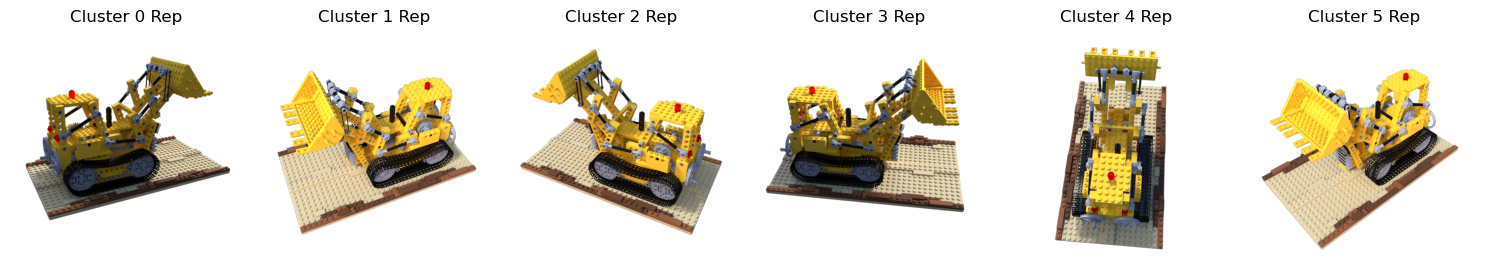

In [ ]:
#select 1 representative image from each cluster and save it
rep_images = []
for i in range(kmean_images.k):
    min_delta_to_mean = float('inf')
    representative_image = None
    for img_path in clusters[i]:
        img_data = kmean_images.read_image(img_path)
        delta = kmean_images.chi2_distance(img_data, kmean_images.generate_k_means()[i])
        if delta < min_delta_to_mean:
            min_delta_to_mean = delta
            representative_image = img_path
    rep_images.append(representative_image)
    print(f"Representative image for cluster {i}: {representative_image}")

#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(1, kmean_images.k, figsize=(15, 3))
for i in range(kmean_images.k):
    img = Image.open(rep_images[i])
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Cluster {i} Rep")
plt.tight_layout()
plt.show()

In [ ]:
def select_n_representative_images(clusters, n=1):
    rep_images = []
    for i in range(len(clusters)):
        cluster_images = clusters[i]
        selected_images = []
        if len(cluster_images) <= n:
            selected_images = cluster_images
        else:
            selected_indices = set()
            while len(selected_indices) < n:
                idx = randint(0, len(cluster_images) - 1)
                selected_indices.add(idx)
            selected_images = [cluster_images[idx] for idx in selected_indices]
        rep_images.append(selected_images)
    return rep_images

In [ ]:
#idea try to cluster taking into account the derived features from images instead of raw pixel values because the same color is bound to appear in different parts of the image